***METRICS TO EVALUATE SEGMENTATION***

In [1]:
import torch
from unet import *
from camvid_unet import *
import sklearn as sk
from deeplab2.deeplabv3 import DeepLabV3Plus
from deeplab2 import encoders

import metrics
from sklearn.metrics import classification_report
from Corine import dataset_corine
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import albumentations as A
import os
import pandas as pd

import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import ListedColormap
import earthpy.plot as ep
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
%config Completer.use_jedi = False

In [2]:
DATA_DIR = '/home/usuaris/imatge/manel.davins/Corine/data'
x_valid_dir = os.path.join(DATA_DIR, 'val_images')
y_valid_dir = os.path.join(DATA_DIR, 'val_labels')

In [3]:
data = dataset_corine.DatasetCorine(x_valid_dir, y_valid_dir, augmentation = None)

In [4]:
###############################################################
#           LOAD THE MODEL THAT YOU WANT TO EVALUATE          #
###############################################################


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load('Corine/final_tunning/model_20.pth');
model.to(device)
model.eval();

In [5]:
###############################################################
#       USE THE MODEL TO PREDICT OVER THE SET                 #
###############################################################

true_masks = []
predicted_masks = []

for n in range(0, len(data)):
    image = data[n]['img']
    true_mask = data[n]['label']
    
    image = image.to(device).unsqueeze(0)#1*3*512*512

    output = model(image)#[1, Nclasses, 512, 512]
    output = torch.sigmoid(output)
    output = output.detach().cpu()
    
    output = output.squeeze(0).numpy() #(512, 512, Nclasses)
    
    output_onelayer = np.argmax(output, axis=0)
    true_mask = true_mask.detach().cpu().numpy()
    
    true_masks.append(true_mask)
    predicted_masks.append(output_onelayer) 
    
y_true = np.reshape(true_masks, -1)
y_pred = np.reshape(predicted_masks, -1)

In [6]:
classes = ["Clouds","Artificial surfaces and constructions","Cultivated areas",
                       "Vineyards","Broadleaf tree cover",
                      "Coniferous tree cover","Herbaceous vegetation",
                      "Moors and Heathland","Sclerophyllous vegetation",
                     "Marshes","Peatbogs","Natural material surfaces",
                      "Permanent snow covered surfaces",
                      "Water bodies"]

***1. GENERAL METRICS (PRECISION, RECALL, F1, ACCURACY)***

In [16]:
print(classification_report(y_true, y_pred, target_names=classes, zero_division=0))

                                       precision    recall  f1-score   support

                               Clouds       0.82      0.96      0.88   1162492
Artificial surfaces and constructions       0.83      0.81      0.82   4401267
                     Cultivated areas       0.80      0.75      0.77  12038018
                            Vineyards       0.60      0.61      0.61   5032627
                 Broadleaf tree cover       0.81      0.75      0.78  15055860
                Coniferous tree cover       0.81      0.79      0.80  13720392
                Herbaceous vegetation       0.67      0.62      0.65   9333587
                  Moors and Heathland       0.55      0.66      0.60   4504743
            Sclerophyllous vegetation       0.56      0.64      0.60   8578286
                              Marshes       0.37      0.46      0.41   1204018
                             Peatbogs       0.15      0.32      0.21    289764
            Natural material surfaces       0.50   

In [7]:
print('Pixel accuracy is {0:.3f}'.format(sk.metrics.accuracy_score(y_true, y_pred)))

Pixel accuracy is 0.714


***2. CONFUSION MATRIX***

In [37]:
conf_mat = confusion_matrix(y_true, y_pred, normalize='true')
dataframe = pd.DataFrame(conf_mat, index = classes, columns=classes)

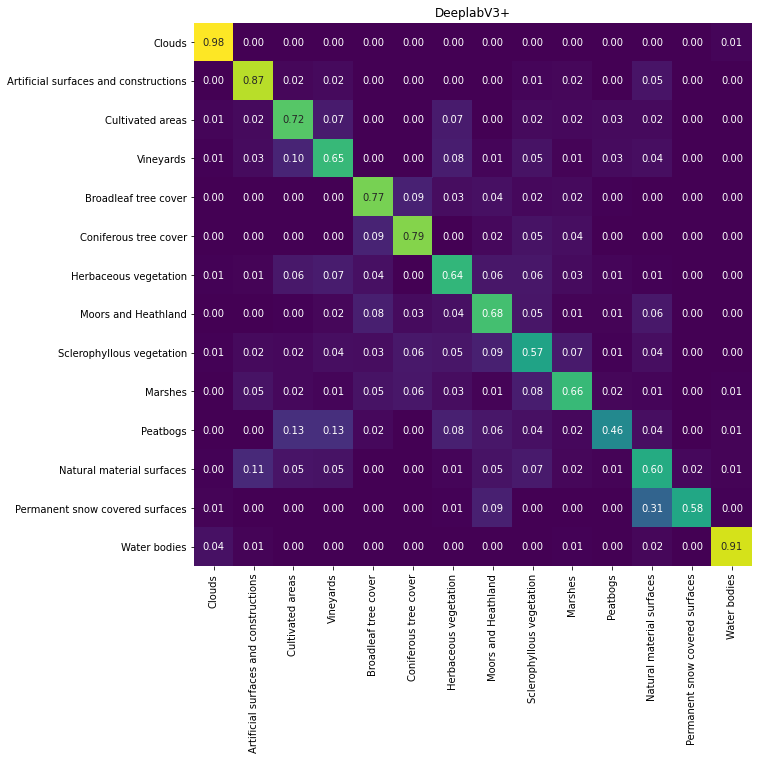

In [38]:
plt.figure(figsize = (10,10))
plt.title("DeeplabV3+")
sn.heatmap(dataframe, annot=True, cmap='viridis',fmt='.2f', cbar=False)
plt.xticks(rotation=90)
plt.savefig("Corine/final_plots/cm_model_19.png")

***3. CLASS IoU and mIoU***

In [8]:
conf_mat = confusion_matrix(y_true, y_pred)

In [9]:
pos = conf_mat.sum(1) # positives
res = conf_mat.sum(0) # prediction
tp = np.diag(conf_mat) # true_positives

pixel_acc = tp.sum()/pos.sum()
IoU_array = (tp / (pos + res - tp))

mean_IoU = IoU_array.mean()

weights = [0.01413434, 0.0476908 , 0.16085254, 0.06444852, 0.22938803,
       0.19021595, 0.12648453, 0.06214654, 0.11891022, 0.01489926,
       0.00380832, 0.03082072, 0.00134249, 0.01178082]

weighted_iou = sum([i*j for (i, j) in zip(IoU_array, weights)])

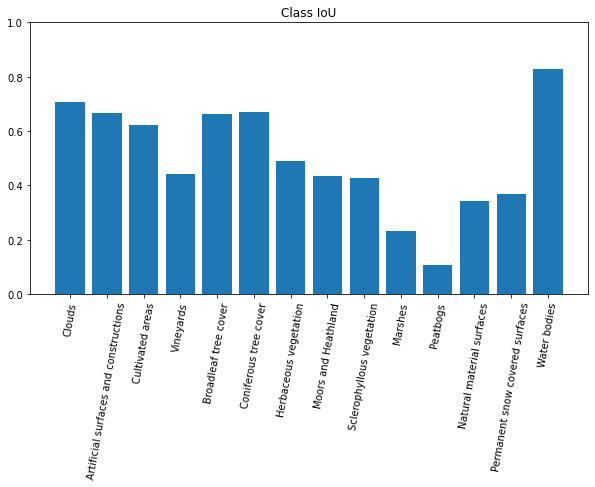

In [50]:
plt.figure(figsize=(10,5))
plt.xticks(rotation=80)
plt.ylim([0,1])
plt.title('Class IoU')
plt.bar(classes, IoU_array);

In [ ]:
data_dict = {'Classes': classes, 'IoU': IoU_array}
df = pd.DataFrame(data_dict)
print("Mean IoU: {0:.3f}  Pixel accuracy: {1:.2f}".format(mean_IoU, weighted_iou))
df

DOUBLE BAR PLOT

In [ ]:
before_IoU_array = [0, 0.6907, 0.6147, 0.42118, 0.63212, 0.6336, 0.4788, 0.4244, 0.4271, 0.2249, 0.103, 0.350, 0.228, 0.904]



plt.figure(figsize=(11,5))
X_axis = np.arange(len(classes))
  
plt.bar(X_axis - 0.15, before_IoU_array, 0.3, label = 'Before')
plt.bar(X_axis + 0.15, IoU_array, 0.3, label = 'After')
  
plt.xticks(X_axis, classes, rotation=80)


plt.legend()
plt.show()


***4. SAMPLE IMAGES***

In [6]:
def unnormalize(dictionary):
    image = dictionary['img']
    mean = dictionary['mean']
    std = dictionary['std']
    image = image.numpy();
    std_expanded = np.expand_dims(np.expand_dims(std, -1), -1)
    mean_expanded = np.expand_dims(np.expand_dims(mean, -1), -1)
    img_un = (image * std_expanded + mean_expanded) * ((2**16)-1)
    img_un = np.clip(img_un, 0, (2**16)-1).astype(np.uint16)
    return img_un

def visualize(dictionary):
    '''
    Three plots: original image, ground truth and prediction.
    '''
    
    #ORIGINAL IMAGE
    original_image = unnormalize(dictionary) 
    
    classes = ["Clouds","Artificial surfaces and constructions","Cultivated areas",
                       "Vineyards","Broadleaf tree cover",
                      "Coniferous tree cover","Herbaceous vegetation",
                      "Moors and Heathland","Sclerophyllous vegetation",
                     "Marshes","Peatbogs","Natural material surfaces",
                      "Permanent snow covered surfaces",
                      "Water bodies"]
    
    col_dict={0:[1.0,1.0,1.0,1.0],
              1:[210.0/255.0,0.0/255.0,0.0/255.0,255.0/255.0],
              2:[253/255.0,211/255.0,39/255.0,255/255.0],
              3:[176/255.0,91/255.0,16/255.0,255/255.0],
              4: [35/255.0,152/255.0,0/255.0,255/255.0],
              5:[8/255.0,98/255.0,0/255.0,255/255.0],
              6:[249/255.0,150/255.0,39/255.0,255/255.0],
              7:[141/255.0,139/255.0,0/255.0,255/255.0],
              8:[95/255.0,53/255.0,6/255.0,255/255.0],
              9:[149/255.0,107/255.0,196/255.0,255/255.0],
              10:[77/255.0,37/255.0,106/255.0,255/255.0],
              11:[154/255.0,154/255.0,154/255.0,255/255.0],
              12:[106/255.0,255/255.0,255/255.0,255/255.0],
              13:[20/255.0,69/255.0,249/255.0,255/255.0]}

    cm = ListedColormap([col_dict[x] for x in col_dict.keys()])
    nclasses = len(classes)
    norm_bins = np.sort([*col_dict.keys()]) + 0.5
    norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)
    norm = matplotlib.colors.BoundaryNorm(norm_bins, nclasses, clip=True)
    fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: classes[norm(x)])
    diff = norm_bins[1:] - norm_bins[:-1]
    tickz = norm_bins[:-1] + diff / 2
    
    #GROUND TRUTH
    label = dictionary['label']
    
    #PREDICTION
    image = dictionary['img']
    image = image.to(device).unsqueeze(0)
    prediction = model(image)#[1, Nclasses, H, W]
    prediction = prediction.detach().cpu().squeeze(0).numpy()#(Nclasses,H, W)
    prediction = np.argmax(prediction, axis=0)
    
    fig, (ax1, ax2, ax3) = plt.subplots( nrows=1, ncols=3,figsize=(15,10))  

    ep.plot_rgb(original_image,rgb=(2,1,0),stretch=True,ax=ax1)
    ax1.set_title('Original')
    ax1.axis('off')
    
    ax2.imshow(label, cmap=cm, norm=norm)
    ax2.set_title('Ground truth')
    ax2.axis('off')
    
    im = ax3.imshow(prediction, cmap=cm, norm=norm)
    ax3.set_title('Prediction')
    ax3.axis('off')
    #cb = fig.colorbar(im, format=fmt, ticks=tickz)
    
    
    plt.tight_layout(pad=0.5, w_pad=2, h_pad=2)
    plt.show()

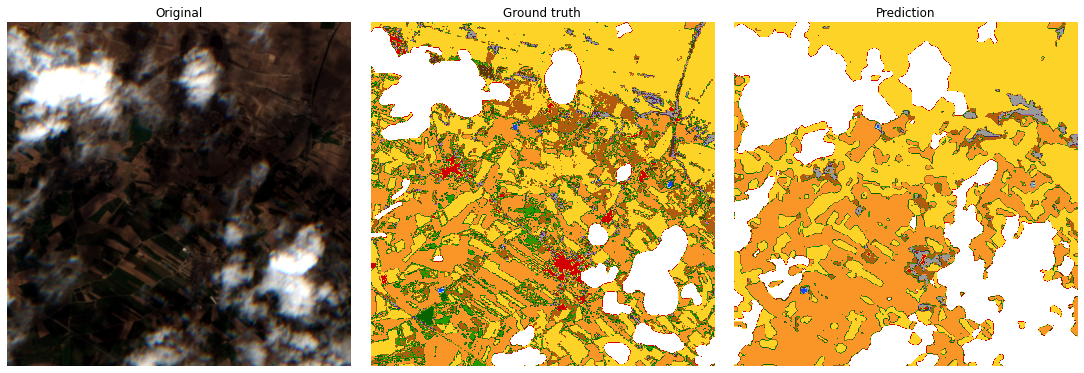

In [12]:
visualize(data[277])